In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def read_file(idx: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    ch1 = pd.read_csv(f"data/F{idx:04}CH1.CSV", header=None)
    ch2 = pd.read_csv(f"data/F{idx:04}CH2.CSV", header=None)
    att1 = float(ch1.at[14, 1])
    att2 = float(ch2.at[14, 1])
    t = ch1[3].to_numpy(np.float64)
    v1 = ch1[4].to_numpy(np.float64) / att1
    v2 = ch2[4].to_numpy(np.float64) / att2
    if idx in (51, 52, 53, 22):
        v1[v1 == -1.024] = np.nan
        v2[v2 == -1.024] = np.nan
    if idx in (23, ):
        v1[v1 == -1.024] = np.nan
        v2[v2 == -0.01024] = np.nan
    if idx in (24, ):
        v1[v1 == -1.024] = np.nan
        v2[v2 == -0.0256] = np.nan
    plt.plot(t, v1)
    plt.plot(t, v2)
    plt.savefig(f"elab/{idx}.png")
    plt.close()
    return (t, v1, v2, idx)


files = list(map(read_file, range(54)))
files1 = list(zip(
    [10., 50., 100., 250., 500., 750., 1e3, 75., 125., 150., 175., 200., 155., 160., 165., 170., 1.5e3, 2e3, 10e3, 50e3, 25., 5., 2., 1., 0.1, 0.01],
    files[2:22] + files[48:]
))
files2 = list(zip(
    [0.01, 0.1, 1., 10., 25., 50., 75., 100., 125., 150., 155., 160., 165., 170., 175., 200., 250., 500., 750., 1e3, 2e3, 5e3, 10e3, 50e3, 100e3, 200e3],
    files[22:48]
))

$$\left|\frac{V_\text{out}}{V_\text{in}}\right| = \frac{1}{\sqrt{1 + \omega^2 \tau^2}}$$

In [129]:
def normal(x: np.ndarray, mu: float = 0, sigma: float = 1) -> np.ndarray:
    return np.exp(-((x - mu) / sigma)**2 / 2) / (np.sqrt(2 * np.pi) * sigma)

def normalize(x: np.ndarray) -> np.ndarray:
    return x / x.sum()

# WEIGHTS = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
W_N = 3
WEIGHTS = normalize(normal(np.linspace(-1, 1, W_N * 2 + 1), sigma=0.5))
print(WEIGHTS)

def media_mobile(ch2: np.ndarray) -> np.ndarray:
    out = []
    N = len(ch2) - 1
    for i in range(N+1):
        weights = WEIGHTS[max(0, W_N-i):W_N+1+N-i]
        weights = weights / weights.sum()
        data = ch2[max(0, i-W_N):min(i+W_N, N)+1]
        out.append(data.dot(weights))
    return np.array(out)

# plt.scatter(np.linspace(-1, 1, 2 * W_N + 1), WEIGHTS)

files1mod = [(f, (t, ch1, media_mobile(media_mobile(ch2)), idx)) for (f, (t, ch1, ch2, idx)) in files1]
files2mod = [(f, (t, ch1, media_mobile(media_mobile(ch2)), idx)) for (f, (t, ch1, ch2, idx)) in files2]

for (_, (t, ch1, ch2mod, idx)) in files1mod + files2mod:
    plt.plot(t, ch1)
    plt.plot(t, ch2mod)
    plt.savefig(f"elab/{idx}mod.png")
    plt.close()

[0.03663285 0.11128076 0.21674532 0.27068215 0.21674532 0.11128076
 0.03663285]


# Prima parte

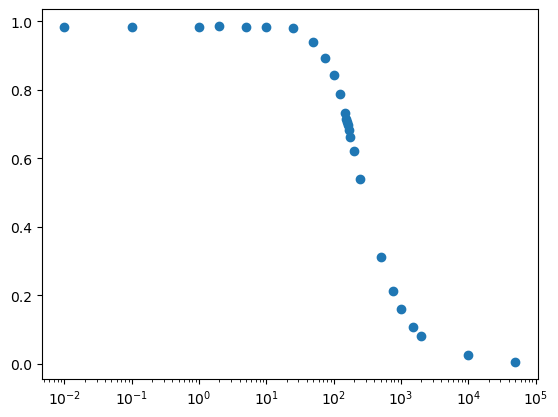

In [130]:
freqs = []
ampiezze = []
for (f, (t, ch1, ch2, _)) in files1mod:
    freqs.append(f)
    Vin = np.nanmax(ch1) - np.nanmin(ch1)
    Vout = np.nanmax(ch2) - np.nanmin(ch2)
    Vout_Vin = Vout / Vin
    ampiezze.append(Vout_Vin)

plt.scatter(freqs, ampiezze)
plt.xscale("log")

$$\varphi = - \arctan\left(\omega \tau\right)$$

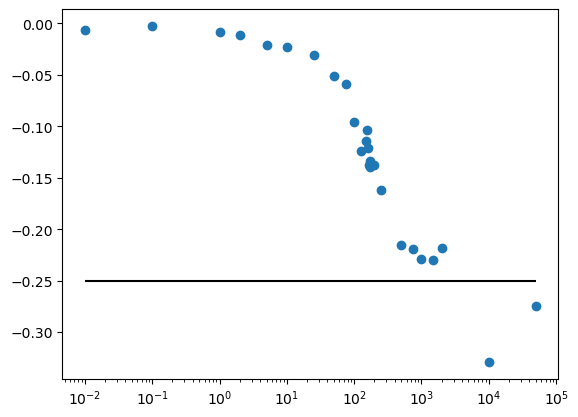

In [131]:
freqs = []
fasi = []
for (f, (t, ch1, ch2, _)) in files1mod:
    freqs.append(f)
    fase = (t[np.nanargmax(ch1)] - t[np.nanargmax(ch2)]) * f
    if fase > 0.5: fase -= 1
    if fase < -1: fase += 1
    fasi.append(fase)

plt.scatter(freqs, fasi)
plt.xscale("log")
plt.hlines([-.25], np.min(freqs), np.max(freqs), color="k")

-1.512e-05 -9.62e-06
∆t = 5.5e-06
T = 2e-05
fase = 0.27499999999999997


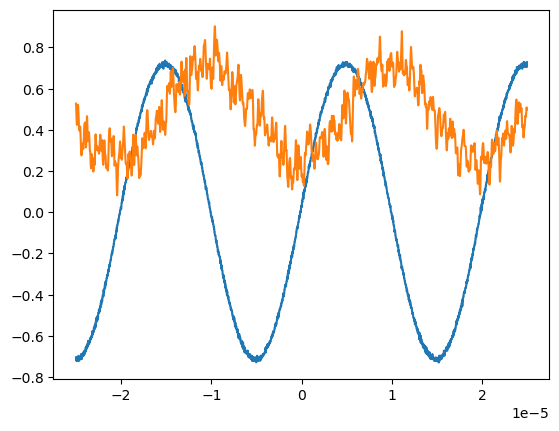

In [132]:
(f, (t, ch1, ch2mod, _)) = files1mod[19]
plt.plot(t, ch1)
plt.plot(t, ch2mod * 100)
fase = ((t2 := t[np.nanargmax(ch2mod)]) - (t1 := t[np.nanargmax(ch1)])) * f
print(t1, t2)
print("∆t =", t2 - t1)
print("T =", 1 / f)
print("fase =", fase)

# Seconda parte

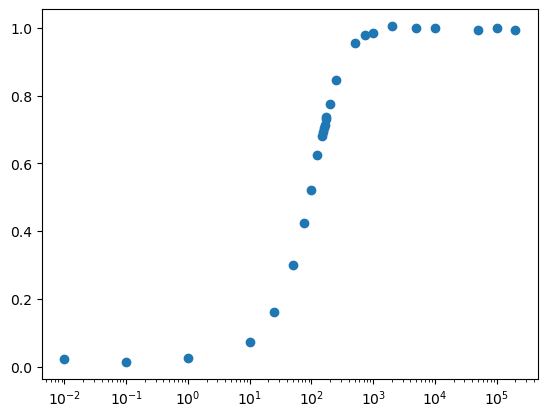

In [94]:
freqs = []
ampiezze = []
for (f, (t, ch1, ch2, _)) in files2:
    freqs.append(f)
    Vin = np.nanmax(ch1) - np.nanmin(ch1)
    Vout = np.nanmax(ch2) - np.nanmin(ch2)
    Vout_Vin = Vout / Vin
    ampiezze.append(Vout_Vin)

plt.scatter(freqs, ampiezze)
plt.xscale("log")

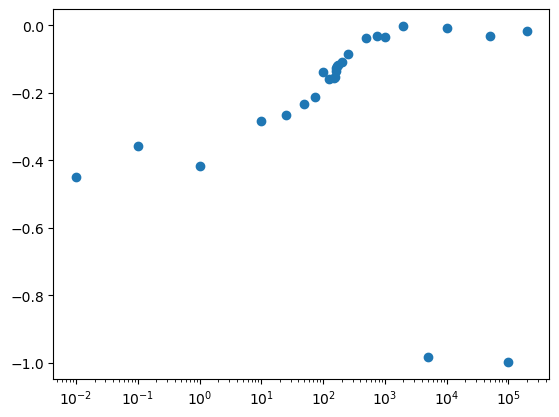

In [95]:
freqs = []
fasi = []
for (f, (t, ch1, ch2, _)) in files2:
    freqs.append(f)
    fase = (t[np.nanargmax(ch2)] - t[np.nanargmax(ch1)]) * f
    if fase < -1:
        fase += 1
    elif fase > 0:
        fase -= 1
    fasi.append(fase)

plt.scatter(freqs, fasi)
plt.xscale("log")

# Altro